In [1]:
!pip install coral_pytorch

In [2]:
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import timm
import random
import shutil
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pytorch_lightning as pl
from coral_pytorch.dataset import corn_label_from_logits
from coral_pytorch.losses import corn_loss

In [109]:
def import_dataset(clip_limit=None,tilegridsize=None,Clahe = False):
    
    if Clahe:
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tilegridsize)
    
    train_dict = {}
    val_dict = {}
    test_dict = {}
    
    train_path = "/kaggle/input/augmented-images/"
    val_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/val/"
    test_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/test/"
    
    for label in os.listdir(train_path):
        train_dict[int(label)] = os.listdir(train_path + label)
    for label in os.listdir(test_path):
        test_dict[int(label)] = os.listdir(test_path + label)
    for label in os.listdir(val_path):
        val_dict[int(label)] = os.listdir(val_path + label)
        
    train_images = {}
    val_images = {}
    test_images = {}
    
    for keys in train_dict.keys():  
        normal_train_images = [np.array(Image.open(train_path + str(keys) + "/" + images)) for images in train_dict[keys]]
        normal_test_images = [np.array(Image.open(test_path + str(keys) + "/" + images)) for images in test_dict[keys]]
        normal_val_images = [np.array(Image.open(val_path + str(keys) + "/" + images)) for images in val_dict[keys]]
        
        if Clahe:
            clahe_train_images = [clahe.apply(np.array(Image.open(train_path + str(keys) + "/" + images))) for images in train_dict[keys]]
            clahe_test_images = [clahe.apply(np.array(Image.open(test_path + str(keys) + "/" + images))) for images in test_dict[keys]]
            clahe_val_images = [clahe.apply(np.array(Image.open(val_path + str(keys) + "/" + images))) for images in val_dict[keys]]
            
            train_images[keys] =  clahe_train_images
            test_images[keys] =  clahe_test_images
            val_images[keys] =  clahe_val_images
            
        else:
            train_images[keys] = normal_train_images
            test_images[keys] = normal_test_images
            val_images[keys] = normal_val_images 
            
            
    return train_images,test_images,val_images

In [4]:
def create_tensors(train_images,test_images,val_images):
    
    trlabel0 = [0 for i in range(len(train_images[0]))]
    trlabel1 = [1 for i in range(len(train_images[1]))]
    trlabel2 = [2 for i in range(len(train_images[2]))]
    trlabel3 = [3 for i in range(len(train_images[3]))]
    trlabel4 = [4 for i in range(len(train_images[4]))]
    
    tslabel0 = [0 for i in range(len(test_images[0]))]
    tslabel1 = [1 for i in range(len(test_images[1]))]
    tslabel2 = [2 for i in range(len(test_images[2]))]
    tslabel3 = [3 for i in range(len(test_images[3]))]
    tslabel4 = [4 for i in range(len(test_images[4]))]
    
    vlabel0 = [0 for i in range(len(val_images[0]))]
    vlabel1 = [1 for i in range(len(val_images[1]))]
    vlabel2 = [2 for i in range(len(val_images[2]))]
    vlabel3 = [3 for i in range(len(val_images[3]))]
    vlabel4 = [4 for i in range(len(val_images[4]))]
    
    
    training_image  = torch.tensor(torch.cat((torch.tensor(train_images[0]),torch.tensor(train_images[1]),torch.tensor(train_images[2]),torch.tensor(train_images[3]),torch.tensor(train_images[4])),0),dtype = torch.float32)
    training_labels = torch.tensor(torch.cat((torch.tensor(trlabel0),torch.tensor(trlabel1),torch.tensor(trlabel2),torch.tensor(trlabel3),torch.tensor(trlabel4)),0))
    training_image = training_image.view(training_image.shape[0],1,224,224)
    
    testing_image  = torch.tensor(torch.cat((torch.tensor(test_images[0]),torch.tensor(test_images[1]),torch.tensor(test_images[2]),torch.tensor(test_images[3]),torch.tensor(test_images[4])),0),dtype = torch.float32)
    testing_labels = torch.tensor(torch.cat((torch.tensor(tslabel0),torch.tensor(tslabel1),torch.tensor(tslabel2),torch.tensor(tslabel3),torch.tensor(tslabel4)),0))
    testing_image = testing_image.view(testing_image.shape[0],1,224,224)
    
    val_image  = torch.tensor(torch.cat((torch.tensor(val_images[0]),torch.tensor(val_images[1]),torch.tensor(val_images[2]),torch.tensor(val_images[3]),torch.tensor(val_images[4])),0),dtype = torch.float32)
    val_labels = torch.tensor(torch.cat((torch.tensor(vlabel0),torch.tensor(vlabel1),torch.tensor(vlabel2),torch.tensor(vlabel3),torch.tensor(vlabel4)),0))
    val_image = val_image.view(val_image.shape[0],1,224,224)
    
    return training_image,training_labels,testing_image,testing_labels,val_image,val_labels

In [57]:
def create_dataset(training_image,training_labels,testing_image,testing_labels,val_image,val_labels,batch_size = 4):
    train_dataset = TensorDataset(training_image,training_labels)
    val_dataset = TensorDataset(val_image,val_labels)
    test_dataset = TensorDataset(testing_image,testing_labels)
    
    train_loader = DataLoader(train_dataset,shuffle= True , batch_size = batch_size)
    val_loader = DataLoader(val_dataset,shuffle = True , batch_size = batch_size)
    test_loader = DataLoader(test_dataset,shuffle = True, batch_size = batch_size)
    
    return train_loader,test_loader,val_loader

In [21]:
def testing(model,test_loader):
    device = 'cuda'
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        test_loss = 0.0
        test_accuracy = 0
        for i,(images, labels) in enumerate(test_loader):

            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            
            loss = corn_loss(outputs, labels, 5)
            
            
            predicted_labels = corn_label_from_logits(outputs).float()
            
            n_samples += labels.size(0)
            n_correct += (predicted_labels == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted_labels.cpu().numpy())

        
        confusion_mat = confusion_matrix(all_labels, all_predictions)


        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the {n_samples} test images:{acc:.4f}%')
        
        return confusion_mat
    

In [110]:
train_images,test_images,val_images = import_dataset(clip_limit = 0.04,tilegridsize=(8,8),Clahe = False)

In [111]:
training_image,training_labels,testing_image,testing_labels,val_image,val_labels = create_tensors(train_images,test_images,val_images)

In [112]:
tr_image = training_image[:,:,65:180,:]
ts_image = testing_image[:,:,65:180,:]
v_image = val_image[:,:,65:180,:]

In [113]:
train_loader,test_loader,val_loader = create_dataset(tr_image,training_labels,ts_image,testing_labels,v_image,val_labels,batch_size = 28)

In [114]:
original_model= torchvision.models.vgg19_bn(pretrained = True)

In [115]:
original_model.features[0] = nn.Conv2d(1,64,kernel_size = (3,3),stride = 1,padding = 1)

In [116]:
original_model.avgpool = nn.AvgPool2d(2)
original_model.classifier = nn.Sequential(
                            nn.Linear(512*3,512),
                            nn.BatchNorm1d(512),
                            nn.ReLU(inplace = True),
                            nn.Linear(512,4))

In [117]:
no_of_layers = 16
for i, params in enumerate(original_model.parameters()):
    if i < no_of_layers:
        params.requires_grad = False

In [118]:
original_model.to('cuda')

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [119]:
optimizer = torch.optim.Adam(original_model.parameters(),lr = 0.0001)

In [120]:
epochs = 8
training_loss = 0.0
training_accuracy = 0
validation_accuracy = 0
device = 'cuda'
for epoch in range(epochs):
    n_samples_train = 0
    n_samples_val = 0
    original_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = original_model(images)
        
        loss = corn_loss(output, labels, 5)
        n_samples_train += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predicted_labels = corn_label_from_logits(output).float()
        training_accuracy += (predicted_labels == labels).sum().item()

        if (i + 1) % 512 == 0:
            print(f'Training - Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item():.4f}')

    print(f'Training Accuracy - Epoch: {epoch + 1}: {training_accuracy * 100 / n_samples_train:.2f}%')
    training_accuracy = 0
    
    original_model.eval()
    with torch.no_grad():
        for i, (val_images, val_labels) in enumerate(val_loader):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_output = original_model(val_images)
            
            loss = corn_loss(val_output,val_labels, 5)
            
            predicted_labels = corn_label_from_logits(val_output).float()
            
            validation_accuracy += (predicted_labels == val_labels).sum().item()
            n_samples_val += val_labels.size(0)

    print(f'Validation Accuracy - Epoch: {epoch + 1}: {validation_accuracy * 100 / n_samples_val:.2f}% Loss: {loss.item():.4f}')
    validation_accuracy = 0

Training Accuracy - Epoch: 1: 56.33%
Validation Accuracy - Epoch: 1: 54.24% Loss: 0.3192
Training Accuracy - Epoch: 2: 71.11%
Validation Accuracy - Epoch: 2: 58.60% Loss: 0.4058
Training Accuracy - Epoch: 3: 78.43%
Validation Accuracy - Epoch: 3: 56.54% Loss: 0.4597
Training Accuracy - Epoch: 4: 82.32%
Validation Accuracy - Epoch: 4: 61.26% Loss: 0.3460
Training Accuracy - Epoch: 5: 86.57%
Validation Accuracy - Epoch: 5: 60.29% Loss: 0.5410
Training Accuracy - Epoch: 6: 89.44%
Validation Accuracy - Epoch: 6: 62.47% Loss: 0.5491
Training Accuracy - Epoch: 7: 92.46%
Validation Accuracy - Epoch: 7: 59.08% Loss: 0.8920
Training Accuracy - Epoch: 8: 94.33%
Validation Accuracy - Epoch: 8: 61.86% Loss: 0.7972


In [121]:
for i, params in enumerate(original_model.parameters()):
        if i < no_of_layers:
            params.requires_grad = True

In [122]:
epochs = 8
training_loss = 0.0
training_accuracy = 0
validation_accuracy = 0
device = 'cuda'
for epoch in range(epochs):
    n_samples_train = 0
    n_samples_val = 0
    original_model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        output = original_model(images)
        
        loss = corn_loss(output, labels, 5)
        n_samples_train += labels.size(0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predicted_labels = corn_label_from_logits(output).float()
        training_accuracy += (predicted_labels == labels).sum().item()

        if (i + 1) % 512 == 0:
            print(f'Training - Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {loss.item():.4f}')

    print(f'Training Accuracy - Epoch: {epoch + 1}: {training_accuracy * 100 / n_samples_train:.2f}%')
    training_accuracy = 0
    
    original_model.eval()
    with torch.no_grad():
        for i, (val_images, val_labels) in enumerate(val_loader):

            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_output = original_model(val_images)
            
            loss = corn_loss(val_output,val_labels, 5)
            
            predicted_labels = corn_label_from_logits(val_output).float()
            
            validation_accuracy += (predicted_labels == val_labels).sum().item()
            n_samples_val += val_labels.size(0)

    print(f'Validation Accuracy - Epoch: {epoch + 1}: {validation_accuracy * 100 / n_samples_val:.2f}% Loss: {loss.item():.4f}')
    validation_accuracy = 0

Training Accuracy - Epoch: 1: 94.84%
Validation Accuracy - Epoch: 1: 58.72% Loss: 0.6919
Training Accuracy - Epoch: 2: 95.29%
Validation Accuracy - Epoch: 2: 63.32% Loss: 0.6472
Training Accuracy - Epoch: 3: 96.20%
Validation Accuracy - Epoch: 3: 60.77% Loss: 0.7613
Training Accuracy - Epoch: 4: 97.07%
Validation Accuracy - Epoch: 4: 56.17% Loss: 0.5580
Training Accuracy - Epoch: 5: 97.13%
Validation Accuracy - Epoch: 5: 61.99% Loss: 0.7371
Training Accuracy - Epoch: 6: 96.93%
Validation Accuracy - Epoch: 6: 61.62% Loss: 0.3915
Training Accuracy - Epoch: 7: 97.52%
Validation Accuracy - Epoch: 7: 61.26% Loss: 0.5221
Training Accuracy - Epoch: 8: 97.82%
Validation Accuracy - Epoch: 8: 63.20% Loss: 0.7281


In [125]:
conf_mat = testing(original_model,test_loader)

Accuracy of the network on the 1656 test images:65.0966%


In [126]:
confusion_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

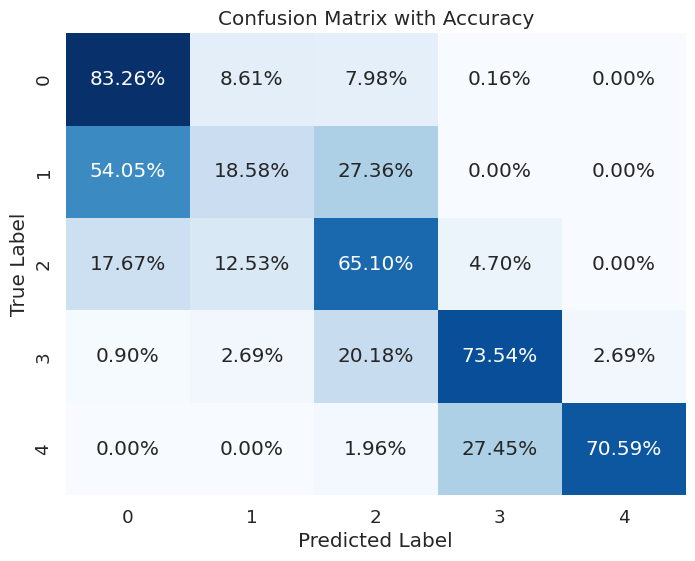

In [127]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mat_norm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix with Accuracy")
plt.show()